In [18]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from scipy.stats import t
from sklearn.metrics import mean_squared_error, r2_score 
import re
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from datetime import date

# Homework #4


The howework is due May 23rd 11:59PM.

## 1. Bike sharing dataset

This is a dataset of bike sharing data from 2011 and 2012 from Washington D.C. and is 
publicly available in [here](http://capitalbikeshare.com/system-data). Read the [README](./data/bike_sharing/Readme.txt) for details.

For this question, construct  

* a decision tree model
* a random forest
* a XGBoost tree model

to predict

1. the weather situation ('weathersit' column) using other columns.
2. the number of bikes ('cnt' column) using other columns.

In [149]:
bike = pd.read_csv('/Users/burak.cakan/Desktop/HW4/data/bike_sharing/day.csv')
bike

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


In [150]:
def doExperiment(xs,ys,model,ts=0.25):
    xtrain,xtest,ytrain,ytest = train_test_split(xs,ys,test_size=ts)
    model.fit(xtrain,ytrain)
    pred = model.predict(xtest)
    acc_score=accuracy_score(ytest, pred)
    return acc_score
N=5

In [151]:
def visualizeR(dataset):
    plt.plot('max_depth','acc_gini', data=dataset, label='gini')
    plt.plot('max_depth','acc_entropy', data=dataset, label='entropy')
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.legend()

# Prediction of the weather situation:

## a. Decision Tree Model

Only 6 columns have an effect on weather. Not to have a conflict between month and season when get_dummies is used, I added 12 to the season. By this way, 13,14,15 and 16 are new season values instead of 1,2,3,4.

In [152]:
bike['season']=bike['season']+12
season_dummy = pd.get_dummies(bike['season'])
month_dummy = pd.get_dummies(bike['mnth'])

features=['temp','atemp','hum','windspeed'] 
target=['weathersit']

xs=pd.concat([month_dummy, season_dummy,bike[features]], axis=1)
ys=bike[target]

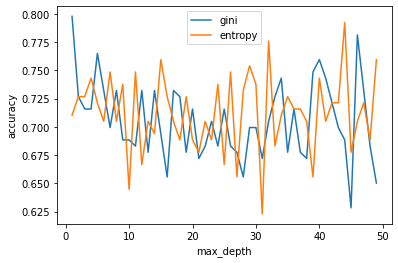

In [153]:
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1,50):
    accuracy=doExperiment(xs,ys,DecisionTreeClassifier(criterion='gini',max_depth=i))
    acc_gini.append(accuracy)
    
    accuracy=doExperiment(xs,ys,DecisionTreeClassifier(criterion='entropy',max_depth=i))
    acc_entropy.append(accuracy)

    max_depth.append(i)

d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
                  'acc_entropy':pd.Series(acc_entropy),
                  'max_depth':pd.Series(max_depth)})
visualizeR(d)

Best prediction is as below:

In [154]:
if max(acc_gini) > max(acc_entropy):
    method='gini'
    depth=acc_gini.index(max(acc_gini))+1
    print('Maximum accuracy in Desicion Tree Model: ', max(acc_gini))
    print('For the maximum accuracy, max_depth: ',acc_gini.index(max(acc_gini))+1)
else:
    method='entropy'
    depth=acc_entropy.index(max(acc_entropy))+1
    print('Maximum accuracy in Desicion Tree Model: ', max(acc_entropy))
    print('For the maximum accuracy, max_depth: ',acc_entropy.index(max(acc_entropy))+1)

Maximum accuracy in Desicion Tree Model:  0.7978142076502732
For the maximum accuracy, max_depth:  1


In [155]:
print('95% Confidence Interval of Accuracy Score:')
accuracies = np.array([doExperiment( xs,
                                     ys,
                                     DecisionTreeClassifier(criterion=method,max_depth=depth))
                        for i in range(N)])
t.interval(0.95,N-1,loc=accuracies.mean(),scale=accuracies.var())

95% Confidence Interval of Accuracy Score:


(0.733774779628733, 0.7372634717373874)

## b. Random Forest 

<ipython-input-150-f20b9c00d5af>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain,ytrain)
<ipython-input-150-f20b9c00d5af>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain,ytrain)
<ipython-input-150-f20b9c00d5af>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain,ytrain)
<ipython-input-150-f20b9c00d5af>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain,ytrain)
<ipython-input-150-f20b9c00d5af>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

<ipython-input-150-f20b9c00d5af>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain,ytrain)
<ipython-input-150-f20b9c00d5af>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain,ytrain)
<ipython-input-150-f20b9c00d5af>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain,ytrain)
<ipython-input-150-f20b9c00d5af>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain,ytrain)
<ipython-input-150-f20b9c00d5af>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

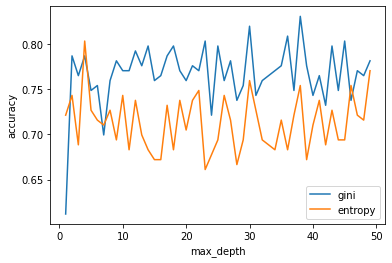

In [156]:
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1,50):
    accuracy=doExperiment(xs,ys,RandomForestClassifier(criterion='gini', max_depth=i))
    acc_gini.append(accuracy)

    accuracy=doExperiment(xs,ys,DecisionTreeClassifier(criterion='entropy', max_depth=i))
    acc_entropy.append(accuracy)
    
    max_depth.append(i)

e = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
                  'acc_entropy':pd.Series(acc_entropy),
                  'max_depth':pd.Series(max_depth)})

visualizeR(e)

In [157]:
if max(acc_gini) > max(acc_entropy):
    method='gini'
    depth=acc_gini.index(max(acc_gini))+1
    print('Maximum accuracy in Random Forest Model: ', max(acc_gini))
    print('For the maximum accuracy, max_depth: ',acc_gini.index(max(acc_gini))+1)
else:
    method='entropy'
    depth=acc_entropy.index(max(acc_entropy))+1
    print('Maximum accuracy in Random Forest Model: ', max(acc_entropy))
    print('For the maximum accuracy, max_depth: ',acc_entropy.index(max(acc_entropy))+1)

Maximum accuracy in Random Forest Model:  0.8306010928961749
For the maximum accuracy, max_depth:  38


In [158]:
print('95% Confidence Interval of Accuracy Score:')
accuracies = np.array([doExperiment( xs,
                                     ys,
                                     RandomForestClassifier(criterion=method,max_depth=depth))
                        for i in range(N)])
t.interval(0.95,N-1,loc=accuracies.mean(),scale=accuracies.var())

95% Confidence Interval of Accuracy Score:


<ipython-input-150-f20b9c00d5af>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain,ytrain)
<ipython-input-150-f20b9c00d5af>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain,ytrain)
<ipython-input-150-f20b9c00d5af>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain,ytrain)
<ipython-input-150-f20b9c00d5af>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain,ytrain)
<ipython-input-150-f20b9c00d5af>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

(0.7833582242441218, 0.7882264752094302)

## c. XGBoost 

In [159]:
accuracies = np.array([doExperiment(xs,
                                     ys,
                                     xgb.XGBClassifier())
                        for i in range(N)])
t.interval(0.95,N-1,loc=accuracies.mean(),scale=accuracies.var())

/Users/burak.cakan/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/burak.cakan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[13:01:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/burak.cakan/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/burak.cakan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[13:01:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/burak.cakan/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/burak.cakan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[13:01:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/burak.cakan/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/burak.cakan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[13:01:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/burak.cakan/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/burak.cakan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[13:01:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(0.7361676447262128, 0.7370563989896343)

According to three models for the prediction of weather, Random Forest had a slightly better performance than other two models.

# Prediction of the number of bikes:

Casual and registered are dependent variables to the target variable (cnt). That's why, I excluded them. 
Because I was aiming to predict a continous and numeric response (cnt), I decided to regressors instead of classifiers.

In [207]:
def doExperiment2(xs,ys,model,ts=0.25):
    xtrain,xtest,ytrain,ytest = train_test_split(xs,ys,test_size=ts)
    model.fit(xtrain,ytrain)
    return model.score(xtest,ytest)

According to my research, model.score calculates R2 score when the regressors are used.

In [11]:
def visualizeR(dataset):
    plt.plot('max_depth','acc_values', data=dataset, label='score')
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.legend()

In [10]:
def depthSelect(accuracy_val):
    depth=accuracy_val.index(max(accuracy_val))+1
    print('Maximum score in Desicion Tree Regression: ', max(accuracy_val))
    print('For the maximum score, max_depth: ',accuracy_val.index(max(accuracy_val))+1)
    return depth

In [164]:
bike['yr']=bike['yr']+17
bike['holiday']=bike['holiday']+19
bike['weekday']=bike['weekday']+21
bike['workingday']=bike['workingday']+28
bike['weathersit']=bike['weathersit']+30

features=['temp','atemp','hum','windspeed'] 
target=['cnt']

xs=pd.concat([pd.get_dummies(bike['season']),pd.get_dummies(bike['yr']), 
              pd.get_dummies(bike['mnth']),pd.get_dummies(bike['holiday']),
              pd.get_dummies(bike['weekday']),pd.get_dummies(bike['workingday']),
              pd.get_dummies(bike['weathersit']),bike[features]],axis=1)
ys=bike[target]

## a. Decision Tree Model: 

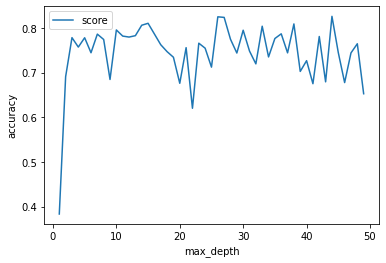

In [165]:
max_depth = []
acc_values = []
for i in range(1,50):
    accuracy=doExperiment2(xs,ys,DecisionTreeRegressor(max_depth=i))
    acc_values.append(accuracy)
    max_depth.append(i)

d = pd.DataFrame({'acc_values':pd.Series(acc_values),'max_depth':pd.Series(max_depth)})
visualizeR(d)

In [166]:
depth = depthSelect(acc_values)

Maximum score in Desicion Tree Regression:  0.8257985674075198
For the maximum score, max_depth:  44


In [168]:
print('95% Confidence Interval of Model Score:')
accuracies = np.array([doExperiment2( xs,
                                     ys,
                                     DecisionTreeRegressor(max_depth=depth))
                        for i in range(N)])
t.interval(0.95,N-1,loc=accuracies.mean(),scale=accuracies.var())

95% Confidence Interval of Model Score:


(0.7390515770744094, 0.7593091398289759)

## b. Random Forest Model:

<ipython-input-161-bd586ea02bf8>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain,ytrain)
<ipython-input-161-bd586ea02bf8>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain,ytrain)
<ipython-input-161-bd586ea02bf8>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain,ytrain)
<ipython-input-161-bd586ea02bf8>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain,ytrain)
<ipython-input-161-bd586ea02bf8>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

<ipython-input-161-bd586ea02bf8>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain,ytrain)
<ipython-input-161-bd586ea02bf8>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain,ytrain)
<ipython-input-161-bd586ea02bf8>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain,ytrain)
<ipython-input-161-bd586ea02bf8>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain,ytrain)
<ipython-input-161-bd586ea02bf8>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

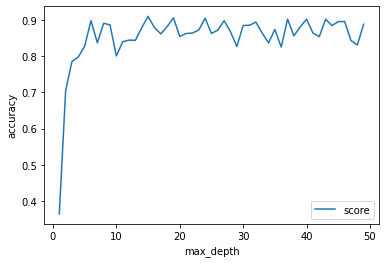

In [169]:
max_depth = []
acc_values = []
for i in range(1,50):
    accuracy=doExperiment2(xs,ys,RandomForestRegressor(max_depth=i))
    acc_values.append(accuracy)
    max_depth.append(i)

d = pd.DataFrame({'acc_values':pd.Series(acc_values),'max_depth':pd.Series(max_depth)})

visualizeR(d)

In [170]:
depth = depthSelect(acc_values)

Maximum score in Desicion Tree Regression:  0.9095475093031143
For the maximum score, max_depth:  15


In [171]:
print('95% Confidence Interval of Model Score:')
accuracies = np.array([doExperiment2( xs,
                                      ys,
                                      DecisionTreeRegressor(max_depth=depth))
                        for i in range(N)])
t.interval(0.95,N-1,loc=accuracies.mean(),scale=accuracies.var())

95% Confidence Interval of Model Score:


(0.7582645806937277, 0.7679557645048553)

## c. XGBoost Model: 

In [135]:
accuracies = np.array([doExperiment2( xs,
                                     ys,
                                     xgb.XGBRegressor())
                        for i in range(N)])
t.interval(0.95,N-1,loc=accuracies.mean(),scale=accuracies.var())

(0.8777788790463982, 0.879259655781098)

According to the models above for count of bikes, XGBoost performed better than other models.

## 2. Education datataset

This dataset is taken from [Kaggle](https://www.kaggle.com/spscientist/students-performance-in-exams). For this dataset, construct a decision tree regression and a XGBoost regression model to predict

1. math score
2. reading score
3. writing score

Beware: you might have to transform the data first before you train and test your models.

In [346]:
education = pd.read_csv('/Users/burak.cakan/Desktop/HW4/StudentsPerformance.csv')
education

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


At that point, I used one-hot encoding for categorical variables. Then, I decided to normalize score values because it is possible to dominate other features which are 0 or 1, with their values ranging from 0 to 100.

In [347]:
from sklearn.preprocessing import Normalizer
yy=pd.concat([education['math score'],education['reading score'],education['writing score']],axis=1)
transformer = Normalizer().fit(yy)  
aa=transformer.transform(yy)
yst_1=pd.DataFrame({'math score':aa[:,0],'reading score':aa[:,1],'writing score':aa[:,2]})

ys_1=education['math score']
ys_2=education['reading score']
ys_3=education['writing score']
xs=pd.concat([pd.get_dummies(education['gender']),pd.get_dummies(education['race/ethnicity']), 
              pd.get_dummies(education['parental level of education']),pd.get_dummies(education['lunch']),
              pd.get_dummies(education['test preparation course']),yst_1['reading score'],yst_1['writing score']],axis=1)

Accuracy measure is not so meaningful for regression models. To understand the quality of the regression models, best measures are described as r2 and adjusted r2 in literature. Hence, I modified the return value of the prediction function which is stated below. 

In [25]:
def doExperiment2(xs,ys,model,ts=0.2):
    xtrain,xtest,ytrain,ytest = train_test_split(xs,ys,test_size=ts)
    model.fit(xtrain,ytrain)
    pred=model.predict(xtest)
    #mse_val=mean_squared_error(ytest,pred,squared=True)
    r2 = r2_score(ytest,pred)
    #n = pred.shape[0]
    #k = xtrain.shape[1]
    #adj_r_sq = 1 - (1 - r2)*(n-1)/(n-1-k)
    return r2


## a. Math Score Prediction

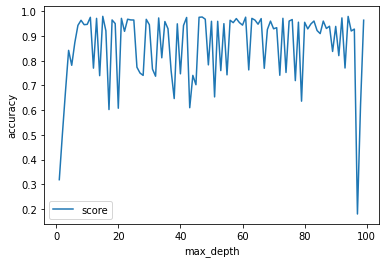

In [349]:
max_depth  = []
acc_values = []
for i in range(1,100):
    accuracy=doExperiment2(xs,yst_1['math score'],DecisionTreeRegressor(criterion='mse', splitter='best',max_depth=i))
    acc_values.append(accuracy)
    max_depth.append(i)

d = pd.DataFrame({'acc_values':pd.Series(acc_values),'max_depth':pd.Series(max_depth)})
visualizeR(d)

In [350]:
depth = depthSelect(acc_values)

Maximum score in Desicion Tree Regression:  0.9797800621731698
For the maximum score, max_depth:  15


In [351]:
print('95% Confidence Interval of Model Score:')
accuracies = np.array([doExperiment2( xs,
                                      yst_1['math score'],
                                      DecisionTreeRegressor(max_depth=depth))
                        for i in range(N)])
t.interval(0.95,N-1,loc=accuracies.mean(),scale=accuracies.var())

95% Confidence Interval of Model Score:


(0.8427307995447183, 0.9132662581214458)

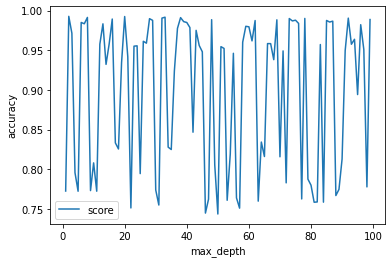

In [352]:
max_depth = []
acc_values = []
for i in range(1,100):
    accuracy=doExperiment2(xs,yst_1['math score'],xgb.XGBRegressor(max_depth=i,eta=0.1,n_estimators=1000))
    acc_values.append(accuracy)
    max_depth.append(i)

d = pd.DataFrame({'acc_values':pd.Series(acc_values),'max_depth':pd.Series(max_depth)})
visualizeR(d)

In [353]:
depth = depthSelect(acc_values)

Maximum score in Desicion Tree Regression:  0.9927347491554679
For the maximum score, max_depth:  2


In [354]:
accuracies = np.array([doExperiment2( xs,
                                      yst_1['math score'],
                                      xgb.XGBRegressor(max_depth=depth,eta=0.1,n_estimators=1000))
                        for i in range(N)])
t.interval(0.95,N-1,loc=accuracies.mean(),scale=accuracies.var())

(0.8694745666923459, 0.9347086543025686)

## b. Reading Score Prediction 

In [355]:
xs=pd.concat([pd.get_dummies(education['gender']),pd.get_dummies(education['race/ethnicity']), 
              pd.get_dummies(education['parental level of education']),pd.get_dummies(education['lunch']),
              pd.get_dummies(education['test preparation course']),yst_1['math score'],yst_1['writing score']],axis=1)


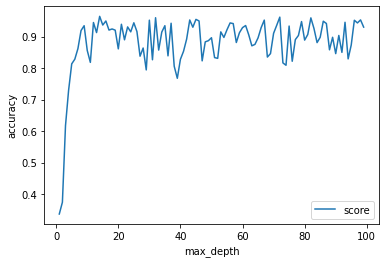

In [356]:
max_depth  = []
acc_values = []
for i in range(1,100):
    accuracy=doExperiment2(xs,yst_1['reading score'],DecisionTreeRegressor(criterion='mse', splitter='best',max_depth=i))
    acc_values.append(accuracy)
    max_depth.append(i)

d = pd.DataFrame({'acc_values':pd.Series(acc_values),'max_depth':pd.Series(max_depth)})
visualizeR(d)

In [357]:
depth = depthSelect(acc_values)

Maximum score in Desicion Tree Regression:  0.964708117215167
For the maximum score, max_depth:  14


In [358]:
print('95% Confidence Interval of Model Score:')
accuracies = np.array([doExperiment2( xs,
                                      yst_1['reading score'],
                                      DecisionTreeRegressor(max_depth=depth))
                        for i in range(N)])
t.interval(0.95,N-1,loc=accuracies.mean(),scale=accuracies.var())

95% Confidence Interval of Model Score:


(0.879596175142556, 0.8944411830074953)

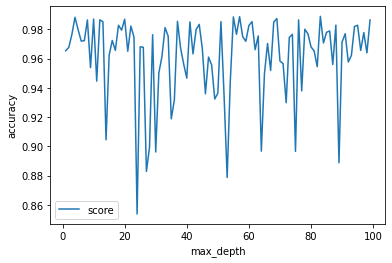

In [359]:
max_depth = []
acc_values = []
for i in range(1,100):
    accuracy=doExperiment2(xs,yst_1['reading score'],xgb.XGBRegressor(max_depth=i,eta=0.1,n_estimators=1000))
    acc_values.append(accuracy)
    max_depth.append(i)

d = pd.DataFrame({'acc_values':pd.Series(acc_values),'max_depth':pd.Series(max_depth)})
visualizeR(d)

In [360]:
depth = depthSelect(acc_values)

Maximum score in Desicion Tree Regression:  0.9889406152735545
For the maximum score, max_depth:  83


In [361]:
accuracies = np.array([doExperiment2( xs,
                                      yst_1['reading score'],
                                      xgb.XGBRegressor(max_depth=depth,eta=0.1,n_estimators=1000))
                        for i in range(N)])
t.interval(0.95,N-1,loc=accuracies.mean(),scale=accuracies.var())

(0.9424332673884555, 0.9557015941502207)

## Writing Score Prediction 

In [363]:
xs=pd.concat([pd.get_dummies(education['gender']),pd.get_dummies(education['race/ethnicity']), 
              pd.get_dummies(education['parental level of education']),pd.get_dummies(education['lunch']),
              pd.get_dummies(education['test preparation course']),yst_1['math score'],yst_1['reading score']],axis=1)


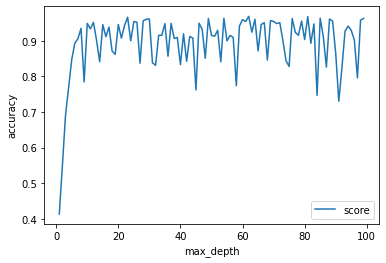

In [364]:
max_depth  = []
acc_values = []
for i in range(1,100):
    accuracy=doExperiment2(xs,yst_1['writing score'],DecisionTreeRegressor(criterion='mse', splitter='best',max_depth=i))
    acc_values.append(accuracy)
    max_depth.append(i)

d = pd.DataFrame({'acc_values':pd.Series(acc_values),'max_depth':pd.Series(max_depth)})
visualizeR(d)

In [365]:
depth = depthSelect(acc_values)

Maximum score in Desicion Tree Regression:  0.9687359358964442
For the maximum score, max_depth:  62


In [367]:
print('95% Confidence Interval of Model Score:')
accuracies = np.array([doExperiment2( xs,
                                      yst_1['writing score'],
                                      DecisionTreeRegressor(max_depth=depth))
                        for i in range(N)])
t.interval(0.95,N-1,loc=accuracies.mean(),scale=accuracies.var())

95% Confidence Interval of Model Score:


(0.9199070568924989, 0.9302851525249253)

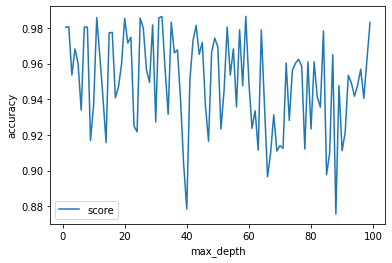

In [368]:
max_depth = []
acc_values = []
for i in range(1,100):
    accuracy=doExperiment2(xs,yst_1['writing score'],xgb.XGBRegressor(max_depth=i,eta=0.1,n_estimators=1000))
    acc_values.append(accuracy)
    max_depth.append(i)

d = pd.DataFrame({'acc_values':pd.Series(acc_values),'max_depth':pd.Series(max_depth)})
visualizeR(d)

In [369]:
depth = depthSelect(acc_values)

Maximum score in Desicion Tree Regression:  0.9865024091655004
For the maximum score, max_depth:  59


In [370]:
accuracies = np.array([doExperiment2( xs,
                                      yst_1['writing score'],
                                      xgb.XGBRegressor(max_depth=depth,eta=0.1,n_estimators=1000))
                        for i in range(N)])
t.interval(0.95,N-1,loc=accuracies.mean(),scale=accuracies.var())

(0.9141745536775271, 0.9247664577905409)

# 3. booking.com Challenge

This dataset is taken from [Booking.com Challenge ACM WSDM 2021](https://www.bookingchallenge.com/).

The original challenge was to predict the final destination city of the trip by looking at the data at hand for each user. For this question, you are free to do whatever you like. Do something interesting with the data :)

In [2]:
booking = pd.read_csv('/Users/burak.cakan/Desktop/booking_dataset/train_set.csv')

features=['checkin','checkout','device_class','affiliate_id','booker_country']
target=['city_id'] 


xtrain=booking[features]
ytrain=booking[target]

booking = pd.read_csv('/Users/burak.cakan/Desktop/booking_dataset/test_set.csv')
xtest=booking[features]
ytest=booking[target]


Like the original problem, I wanted to predict the city_id in order to promote the user.
I assumed checkin, checkout, device_class, affiliate_id and booker_country as independent features. 
Because the dataset is large enough, I only wanted to use train_set.csv file and split this file into train and test.
And 'hotel_country' and city_id should be dependent, so I chose one of them as target.

In [3]:
ytrain

,city_id
0,8183
1,15626
2,60902
3,30628
4,38677
...,...
1166830,20345
1166831,17944
1166832,47075
1166833,228


I checked the data types of each feature in my dataset:

In [4]:
booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378667 entries, 0 to 378666
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   user_id         378667 non-null  int64 
 1   checkin         378667 non-null  object
 2   checkout        378667 non-null  object
 3   device_class    378667 non-null  object
 4   affiliate_id    378667 non-null  int64 
 5   booker_country  378667 non-null  object
 6   utrip_id        378667 non-null  object
 7   city_id         378667 non-null  int64 
 8   hotel_country   308005 non-null  object
dtypes: int64(3), object(6)
memory usage: 26.0+ MB


At first, I wanted to apart the year, month and day from the date of checkin and checkout because apart from the full date, this one should be more meaningful becuse of possible seasonality in the habit of vacation.

In [6]:
aa=np.zeros((len(xtrain['checkin']),3))
for i in range(len(xtrain['checkin'])):
    #aa[i][0]=booking['checkin'][i]
    x = re.split("\-", xtrain['checkin'][i])
    for j in range(3):
        aa[i][j]=x[j]
checkin_xtrain_new=pd.DataFrame({'checkin_year':aa[:,0],'checkin_month':aa[:,1],'checkin_day':aa[:,2]}).astype('int64').astype('category')        

bb=np.zeros((len(xtest['checkin']),3))
for i in range(len(xtest['checkin'])):
    x = re.split("\-", xtest['checkin'][i])
    for j in range(3):
        bb[i][j]=x[j]
checkin_xtest_new=pd.DataFrame({'checkin_year':bb[:,0],'checkin_month':bb[:,1],'checkin_day':bb[:,2]}).astype('int64').astype('category')  

cc=np.zeros((len(xtrain['checkout']),3))
for i in range(len(xtrain['checkout'])):
    x = re.split("\-", xtrain['checkout'][i])
    for j in range(3):
        aa[i][j]=x[j]
checkout_xtrain_new=pd.DataFrame({'checkout_year':aa[:,0],'checkout_month':aa[:,1],'checkout_day':aa[:,2]}).astype('int64').astype('category')        

dd=np.zeros((len(xtest['checkout']),3))
for i in range(len(xtest['checkout'])):
    x = re.split("\-", xtest['checkout'][i])
    for j in range(3):
        bb[i][j]=x[j]
checkout_xtest_new=pd.DataFrame({'checkout_year':bb[:,0],'checkout_month':bb[:,1],'checkout_day':bb[:,2]}).astype('int64').astype('category')   


dummy_dates_train=pd.concat([checkin_xtrain_new,checkout_xtrain_new],axis=1)
dummy_dates_test=pd.concat([checkin_xtest_new,checkout_xtest_new],axis=1)




Then,I concataneted other features with the aparted date columns.

In [54]:
dummies_train=pd.concat([pd.get_dummies(dummy_dates_train),
                         pd.get_dummies(xtrain['device_class']),
                         pd.get_dummies(xtrain['affiliate_id']),
                         pd.get_dummies(xtrain['booker_country'])],axis=1)


In [28]:
dummies_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166835 entries, 0 to 1166834
Columns: 3353 entries, checkin_year_2015 to The Devilfire Empire
dtypes: uint8(3353)
memory usage: 3.6 GB


In [8]:
dummies_test=pd.concat([pd.get_dummies(dummy_dates_test),
                         pd.get_dummies(xtest['device_class']),
                         pd.get_dummies(xtest['affiliate_id']),
                         pd.get_dummies(xtest['booker_country'])],axis=1)


In [9]:
dummies_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378667 entries, 0 to 378666
Columns: 2122 entries, checkin_year_2015 to The Devilfire Empire
dtypes: uint8(2122)
memory usage: 766.3 MB


In [14]:
def doExperiment(xs,ys,model,ts=0.2):
    xtrain,xtest,ytrain,ytest = train_test_split(xs,ys,test_size=ts)
    model.fit(xtrain,ytrain)
    return model.score(xtest,ytest)
N=5

Because of high speed and convenience to categorical data, I wanted to use decision tree classifier. 
Firstly, I wanted to find a good depth value from 0 to 10.

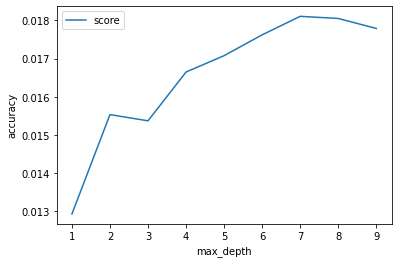

In [15]:
max_depth = []
acc_values = []
for i in range(1,10):
    accuracy=doExperiment(dummies_train,ytrain,DecisionTreeClassifier(criterion='gini',max_depth=i))
    acc_values.append(accuracy)
    max_depth.append(i)

d = pd.DataFrame({'acc_values':pd.Series(acc_values),'max_depth':pd.Series(max_depth)})
visualizeR(d)

This full data took too much time, so I decided to move forward with taking samples.
And I wanted to investigate broader range of depth.

In [ ]:
sample_xs = dummies_train.sample(frac=0.1, random_state=1)
sample_ys = ytrain.sample(frac=0.1, random_state=1)

max_depth = []
acc_values = []
for i in range(1,100):
    accuracy=doExperiment(sample_xs,sample_ys,DecisionTreeClassifier(criterion='gini',max_depth=i))
    acc_values.append(accuracy)
    max_depth.append(i)

d = pd.DataFrame({'acc_values':pd.Series(acc_values),'max_depth':pd.Series(max_depth)})



As you see below, the result is very bad at all:

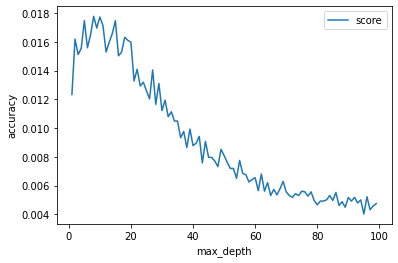

In [12]:
visualizeR(d)

Then I wanted to make some modifications and implementations on dataset. 
1. I will calculate the accomaditon period by subtracting checkin and checkout dates. 
2. Because I am using accomodation period, I didn't need checkout date.
3. The year can be eliminated.

In [5]:
aa=np.zeros((len(xtrain['checkin']),3))
for i in range(len(xtrain['checkin'])):
    #aa[i][0]=booking['checkin'][i]
    x = re.split("\-", xtrain['checkin'][i])
    for j in range(3):
        aa[i][j]=x[j]
checkin_xtrain_new=pd.DataFrame({'checkin_year':aa[:,0],'checkin_month':aa[:,1]}).astype('int64').astype('category')        

#dummy_dates_train=pd.concat([checkin_xtrain_new,checkout_xtrain_new],axis=1)

dummies_train=pd.concat([pd.get_dummies(checkin_xtrain_new),
                         pd.get_dummies(xtrain['device_class']),
                         pd.get_dummies(xtrain['affiliate_id']),
                         pd.get_dummies(xtrain['booker_country']),
                         ytrain],
                        axis=1)


In [6]:
xtrain['checkin'] = pd.to_datetime(xtrain['checkin'])
xtrain['checkout'] = pd.to_datetime(xtrain['checkout'])
a=xtrain['checkout']-xtrain['checkin']
accomodation_period = pd.DataFrame({'accomodation_period':a.dt.days})
b= xtrain['checkin'].dt.day_name() 
checkin_day= pd.DataFrame({'checkin_day':b})
calculated_features= pd.concat([accomodation_period, pd.get_dummies(checkin_day)],axis=1)

new_train=pd.concat([dummies_train,calculated_features], axis=1)

For bagging classifiers, ravel function was a must. So I modified my function:

In [15]:
def doExperiment_bagging(xs,ys,model,ts=0.2):
    xtrain,xtest,ytrain,ytest = train_test_split(xs,ys,test_size=ts)
    model.fit(xtrain,ytrain.values.ravel())
    return model.score(xtest,ytest.values.ravel())
N=5

Decision tree classifier didn't work again. Then I wanted to try other classifiers and regressor.

In [23]:
accuracies=[]
N=20
for i in range(N):
    sample_dataset = new_train.sample(frac=0.05, random_state=1)
    sample_ys = sample_dataset['city_id']
    sample_xs = sample_dataset.loc[:, new_train.columns != 'city_id']
    accuracy  = doExperiment(sample_xs,sample_ys,DecisionTreeClassifier(criterion='gini',max_depth=5))
    accuracies.append(accuracy)
    
accuracies=np.array(accuracies)
t.interval(0.95,N-1,loc=accuracies.mean(),scale=accuracies.var())

(0.0178086729367518, 0.017815630773934638)

In [24]:
accuracies=[]
N=20
for i in range(N):
    sample_dataset = new_train.sample(frac=0.05, random_state=1)
    sample_ys = sample_dataset['city_id']
    sample_xs = sample_dataset.loc[:, new_train.columns != 'city_id']
    accuracy  = doExperiment(sample_xs,sample_ys,KNeighborsClassifier())
    accuracies.append(accuracy)
    
accuracies=np.array(accuracies)
t.interval(0.95,N-1,loc=accuracies.mean(),scale=accuracies.var())


(0.0042155547103009654, 0.00421704448414586)

In [26]:
accuracies=[]
N=20
for i in range(N):
    sample_dataset = new_train.sample(frac=0.05, random_state=1)
    sample_ys = sample_dataset['city_id']
    sample_xs = sample_dataset.loc[:, new_train.columns != 'city_id']
    accuracy  = doExperiment2(sample_xs,sample_ys,DecisionTreeRegressor(criterion='mse', splitter='best',max_depth=5))
    accuracies.append(accuracy)
    
accuracies=np.array(accuracies)
t.interval(0.95,N-1,loc=accuracies.mean(),scale=accuracies.var())

(-0.0019204531089940808, -0.0019164718916689575)

In [27]:
accuracies=[]
N=20
for i in range(N):
    sample_dataset = new_train.sample(frac=0.05, random_state=1)
    sample_ys = sample_dataset['city_id']
    sample_xs = sample_dataset.loc[:, new_train.columns != 'city_id']
    accuracy  = doExperiment2(sample_xs,sample_ys,xgb.XGBRegressor())
    accuracies.append(accuracy)
    
accuracies=np.array(accuracies)
t.interval(0.95,N-1,loc=accuracies.mean(),scale=accuracies.var())

(-0.005857707928236923, -0.005850775180228406)

In [28]:
accuracies=[]
N=20
for i in range(N):
    sample_dataset = new_train.sample(frac=0.05, random_state=1)
    sample_ys = sample_dataset['city_id']
    sample_xs = sample_dataset.loc[:, new_train.columns != 'city_id']
    accuracy  = doExperiment_bagging(sample_xs,sample_ys,AdaBoostClassifier())
    accuracies.append(accuracy)

accuracies=np.array(accuracies)
t.interval(0.95,N-1,loc=accuracies.mean(),scale=accuracies.var())

(0.013499385052577072, 0.013503785741835474)

In [29]:
accuracies=[]
N=20
for i in range(N):
    sample_dataset = new_train.sample(frac=0.05, random_state=1)
    sample_ys = sample_dataset['city_id']
    sample_xs = sample_dataset.loc[:, new_train.columns != 'city_id']
    accuracy  = doExperiment_bagging(sample_xs,sample_ys,MLPClassifier())
    accuracies.append(accuracy)

accuracies=np.array(accuracies)
t.interval(0.95,N-1,loc=accuracies.mean(),scale=accuracies.var())

/Users/burak.cakan/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/burak.cakan/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/burak.cakan/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/burak.cakan/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/burak.cakan/opt/anaconda3/lib/python

Traceback (most recent call last):
  File "/Users/burak.cakan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-ca011fbbc7ad>", line 8, in <module>
    accuracy  = doExperiment_bagging(sample_xs,sample_ys,MLPClassifier())
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/burak.cakan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2045, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/burak.cakan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1170, in get_records
    return _fixed_getinnerframes(etb, number_of_l


KeyboardInterrupt



Because MLP classier takes too much time, I cancelled manually in the fifth iteration.

In [32]:
accuracies=np.array(accuracies)
t.interval(0.95,3,loc=accuracies.mean(),scale=accuracies.var())

(0.0058055682705333645, 0.005806395051088026)

As a result, I didn't end up finding a good predictive model. 
Because AdaBoostClassifier,XGBRegressor and MLPClassifier took nearly one day to compute separately,
I couldn't rearrange the dataset and set a new model.
With these findings, I can say that dataset is not appropriate for prediction.